# 원본 데이터를 생성하는 AutoEncoder
### 설계 순서
1. 모듈 임포트
2. 딥러닝 모델 설계시 활용하는 장비 확인
3. FashionMNIST 데이터 다운로드하기
4. 데이터 확인하기
5. AutoEncoder 모델 설계
6. Optimizer, Objective Function 설정
7. 오토인코더 모델 학습을 진행하며 성능 확인 함수 지정
8. 오토인코더 학습 실행하며 Test set의 Reconstruction Error 확인

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [2]:
BATCH_SIZE = 32  # 모델 학습시 데이터를 32개씩 끊어서 실행
EPOCHS = 10      # 전체 데이터셋을 10번 만큼 반복해 학습

In [3]:
train_dataset = datasets.FashionMNIST(root='./data/FashionMNIST', train=True, download=True, transform = transforms.ToTensor())
test_dataset = datasets.FashionMNIST(root='./data/FashionMNIST', train=False, transform = transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=True)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST\FashionMNIST\raw\train-images-idx3-ubyte.gz to ./data/FashionMNIST\FashionMNIST\raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./data/FashionMNIST\FashionMNIST\raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./data/FashionMNIST\FashionMNIST\raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST\FashionMNIST\raw



D:\download\Anaconda\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [6]:
# 모델 설계
class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 512),  # 이미지를 텐서로 변환
            nn.ReLU(),                # 렐루 비선형 함수 적용
            nn.Linear(512, 256),      # 세번째 레이어의 노드 수를 256으로 설정
            nn.ReLU(),                # 렐루 비선형 함수 적용
            nn.Linear(256, 32),       
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(32, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 28 * 28)
        )
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [7]:
# 옵티마이저와 Loss 설정
model = AE()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # 옵티마이저 아담 사용
criterion = nn.MSELoss()                                    # 입력 이미지와 복원 이미지 간의 차이를 계산하기 위해 criterion 설정

print(model)

AE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=784, bias=True)
  )
)


In [15]:
# 학습하며 모델 성능 확인 함수
def train(model, train_loader, optimizer, log_interval):
    model.train()   # 모델을 학습 상태로 지정
    for batch_idx, (image, _) in enumerate(train_loader):  # 미니 배치 별로 데이터 받기
        image = image.view(-1, 28*28)                      # 2차원 이미지 데이터를 1차원으로 변환
        target = image.view(-1, 28*28)                     # 똑같쥬?
        optimizer.zero_grad()                              # 옵티마이져 그래디언트를 초기화한다.
        encoded, decoded = model(image)                    # 계산
        loss = criterion(decoded, target)                  # 로스값 계산
        loss.backward()                                    # 로스값으로 계산된 그래디언트 값을 각 파라미터에 할당
        optimizer.step()                                   # 파라미터 없데이트
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{}({:.0f}%)]\tTrain Loss:{:.6f}'.format(Epoch, batch_idx*len(image), len(train_loader.dataset), 100. * batch_idx / len(train_loader), loss.item()))

In [11]:
# 모델 성능 확인
def evaluate(model, test_loader):
    model.eval()                                           # 모델을 평가 상태로 지정
    test_loss = 0                                          # 
    real_image = []                                        # 실제 이미지 데이터가 저장되는 리스트
    gen_image = []                                         # 오토인코더로 생성되는 이미지 데이터가 저장되는 리스트
    with torch.no_grad():                                  # 평가 시에는 파라미터 값 고정
        for image, _ in test_loader:                       
            image = image.view(-1, 28*28)                  # 
            target = image.view(-1, 28*28)
            encoded, decoded = model(image)                # 모델 값 계산
            
            test_loss += criterion(decoded, image).item()  # 이미지 간의 MeanSquaredError 를 계산해 test_loss 업데이트
            real_image.append(image)                       # 이미지를 read_image에 추가
            gen_image.append(decoded)                      # 생성된 이미지를 gne_image에 추가
    test_loss /= len(test_loader.dataset)                  # test_loss를 미니배치만큼 나눠 평균을 구한다
    return test_loss, real_image, gen_image                # 반환

Train Epoch: 1 [0/60000(0%)]	Train Loss:0.171653
Train Epoch: 1 [6400/60000(11%)]	Train Loss:0.026028
Train Epoch: 1 [12800/60000(21%)]	Train Loss:0.024986
Train Epoch: 1 [19200/60000(32%)]	Train Loss:0.023371
Train Epoch: 1 [25600/60000(43%)]	Train Loss:0.021261
Train Epoch: 1 [32000/60000(53%)]	Train Loss:0.019720
Train Epoch: 1 [38400/60000(64%)]	Train Loss:0.017452
Train Epoch: 1 [44800/60000(75%)]	Train Loss:0.018268
Train Epoch: 1 [51200/60000(85%)]	Train Loss:0.012649
Train Epoch: 1 [57600/60000(96%)]	Train Loss:0.013648

[EPOCH : 1], 	 Test Loss : 0.0005


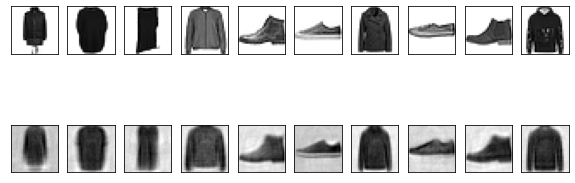

Train Epoch: 2 [0/60000(0%)]	Train Loss:0.013894
Train Epoch: 2 [6400/60000(11%)]	Train Loss:0.015122
Train Epoch: 2 [12800/60000(21%)]	Train Loss:0.011965
Train Epoch: 2 [19200/60000(32%)]	Train Loss:0.013085
Train Epoch: 2 [25600/60000(43%)]	Train Loss:0.014325
Train Epoch: 2 [32000/60000(53%)]	Train Loss:0.014237
Train Epoch: 2 [38400/60000(64%)]	Train Loss:0.013853
Train Epoch: 2 [44800/60000(75%)]	Train Loss:0.012573
Train Epoch: 2 [51200/60000(85%)]	Train Loss:0.015576
Train Epoch: 2 [57600/60000(96%)]	Train Loss:0.013652

[EPOCH : 2], 	 Test Loss : 0.0004


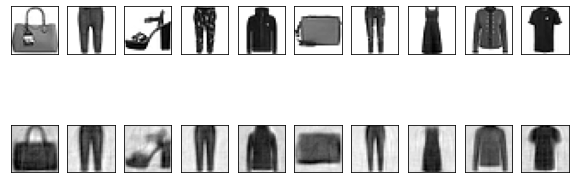

Train Epoch: 3 [0/60000(0%)]	Train Loss:0.011233
Train Epoch: 3 [6400/60000(11%)]	Train Loss:0.011933
Train Epoch: 3 [12800/60000(21%)]	Train Loss:0.011750
Train Epoch: 3 [19200/60000(32%)]	Train Loss:0.010061
Train Epoch: 3 [25600/60000(43%)]	Train Loss:0.011271
Train Epoch: 3 [32000/60000(53%)]	Train Loss:0.009344
Train Epoch: 3 [38400/60000(64%)]	Train Loss:0.013228
Train Epoch: 3 [44800/60000(75%)]	Train Loss:0.011578
Train Epoch: 3 [51200/60000(85%)]	Train Loss:0.011806
Train Epoch: 3 [57600/60000(96%)]	Train Loss:0.009879

[EPOCH : 3], 	 Test Loss : 0.0004


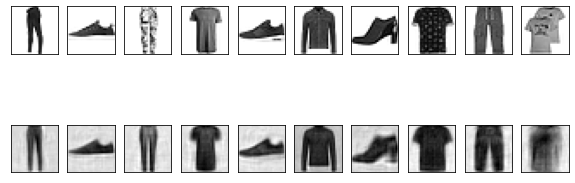

Train Epoch: 4 [0/60000(0%)]	Train Loss:0.010920
Train Epoch: 4 [6400/60000(11%)]	Train Loss:0.011966
Train Epoch: 4 [12800/60000(21%)]	Train Loss:0.012901
Train Epoch: 4 [19200/60000(32%)]	Train Loss:0.010550
Train Epoch: 4 [25600/60000(43%)]	Train Loss:0.014497
Train Epoch: 4 [32000/60000(53%)]	Train Loss:0.011486
Train Epoch: 4 [38400/60000(64%)]	Train Loss:0.012186
Train Epoch: 4 [44800/60000(75%)]	Train Loss:0.009095
Train Epoch: 4 [51200/60000(85%)]	Train Loss:0.011218
Train Epoch: 4 [57600/60000(96%)]	Train Loss:0.008789

[EPOCH : 4], 	 Test Loss : 0.0003


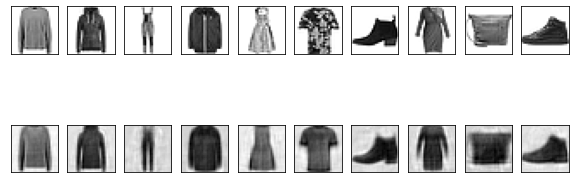

Train Epoch: 5 [0/60000(0%)]	Train Loss:0.011588
Train Epoch: 5 [6400/60000(11%)]	Train Loss:0.009092
Train Epoch: 5 [12800/60000(21%)]	Train Loss:0.011119
Train Epoch: 5 [19200/60000(32%)]	Train Loss:0.010989
Train Epoch: 5 [25600/60000(43%)]	Train Loss:0.009303
Train Epoch: 5 [32000/60000(53%)]	Train Loss:0.009821
Train Epoch: 5 [38400/60000(64%)]	Train Loss:0.008288
Train Epoch: 5 [44800/60000(75%)]	Train Loss:0.010462
Train Epoch: 5 [51200/60000(85%)]	Train Loss:0.011353
Train Epoch: 5 [57600/60000(96%)]	Train Loss:0.011703

[EPOCH : 5], 	 Test Loss : 0.0003


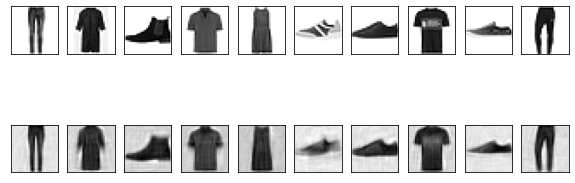

Train Epoch: 6 [0/60000(0%)]	Train Loss:0.010019


In [ ]:
# 오토인코더 학습을 실행하며 테스트 셋의 Reconstruction Error 확인
for Epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, real_image, gen_image = evaluate(model, test_loader)
    print('\n[EPOCH : {}], \t Test Loss : {:.4f}'.format(Epoch, test_loss))
    f, a = plt.subplots(2, 10, figsize=(10, 4))
    for i in range(10):
        img = np.reshape(real_image[0][i], (28, 28))
        a[0][i].imshow(img, cmap='gray_r')
        a[0][i].set_xticks(())
        a[0][i].set_yticks(())
    
    for i in range(10):
        img = np.reshape(gen_image[0][i], (28, 28))
        a[1][i].imshow(img, cmap='gray_r')
        a[1][i].set_xticks(())
        a[1][i].set_yticks(())
    plt.show()